<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 2: deep learning для обработки звука</center></h2>

-----
-----

**Summary этого ноутбука:** в целом все работает, в заданиях 4, 5 и 6 тоже удалось добиться требуемого значения accuracy. В этих заданиях для обучения требовалось, соответственно, 10, 20 и 30 эпох. Эксперименты в основном были связаны с количеством эпох, learning rate'ом и параметром max_freq для 6-го задания. Указанные в ноутбуке параметры позволяют достичь требуемого значения accuracy.

-----
-----

# Введение

В этом задании Вы поработаете и разберетесь в деталях с форматами представления аудиоданных в задачах глубинного обучения, а так же напишете несколько моделей для классификации аудиозаписей.

В процессе выполнения Вы познакомитесь:
* С алгоритмом построения Мел-спектрограммы
* Рекуррентными и сверточными классификаторами аудиоданных
* Алгоритмом аугментации аудиоданных SpecAugment

In [ ]:
!pip install torch==2.1.2 torchaudio==2.1.2 numpy==1.20.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 50.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidi

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torchaudio
from IPython import display
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset

%matplotlib inline

# assert torch.__version__.startswith("1.8.0")
# assert torchaudio.__version__ == "0.8.0"

device = "cuda:0"

# Классификация аудиозаписей.

В этом домашнем задании Вам предстоит классифицировать аудиозаписи из датасета [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html).

Данный датасет состоит из 8732 записей, разбитых на train/val/test датасеты.

![image](https://paperswithcode.com/media/datasets/UrbanSound8K-0000003722-02faef06.jpg)

Каждая аудиозапись содержит запись шума города и принадлежит одному из 10 классов:

`[air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music]`


## Задание 1 (1 балл). Знакомство с данными.

- Скачайте датасет из [Google Drive](https://drive.google.com/drive/folders/1Q1mgopM_aQToKdSRlTI9zFW83sOqvrCS?usp=sharing) c и распакуйте в папку `./data`.
- Положите разархивированные данные рядом с юпитерской тетрадкой. Если вы работаете в колабе, залейте данные на свой гугл-диск и воспользуйтесь кодом ниже для синхронизации тетрадки с ним (это поможет не подгружать их по 10 раз).

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


- Напишите `AudioDataset` класс, который будет принимать путь к файлам `train_part.csv` и `val_part.csv` и возращать тройки объектов `(x, y, len)`, где `x` - аудиозапись, `y` - класс аудиозаписи, `len` - длина аудиозаписи. Аудиозаписи **не должны постоянно храниться в RAM**, подгрузку _wav_ файлов надо сделать при запросе через `__getitem__` метод. Кроме того, надо сделать паддинг аудиозаписи - если она короче чем `pad_size` параметр, надо дополнять ее нулями.

- С помощью функции `display.Audio` проиграйте в ноутбуке пару аудиозаписей.

In [ ]:
# скачаем и распакуем данные
!rm -r ./data
!mkdir ./data/
!pip install gdown
!cd ./data && gdown --id '1057RRnXefWOCvpzjSnRA-Xl-O3NnX8Vq' && unzip HW2_dataset

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: urbansound8k/data/712.wav  
  inflating: urbansound8k/data/1286.wav  
  inflating: urbansound8k/data/7768.wav  
  inflating: urbansound8k/data/855.wav  
  inflating: urbansound8k/data/1319.wav  
  inflating: urbansound8k/data/15.wav  
  inflating: urbansound8k/data/2610.wav  
  inflating: urbansound8k/data/3268.wav  
  inflating: urbansound8k/data/5619.wav  
  inflating: urbansound8k/data/6310.wav  
  inflating: urbansound8k/data/6304.wav  
  inflating: urbansound8k/data/4513.wav  
  inflating: urbansound8k/data/2162.wav  
  inflating: urbansound8k/data/2604.wav  
  inflating: urbansound8k/data/841.wav  
  inflating: urbansound8k/data/699.wav  
  inflating: urbansound8k/data/6462.wav  
  inflating: urbansound8k/data/869.wav  
  inflating: urbansound8k/data/8467.wav  
  inflating: urbansound8k/data/7754.wav  
  inflating: urbansound8k/data/7032.wav  
  inflating: urbansound8k/data/3254.wav  
  inflating: ur

In [ ]:
# классы данных
classes = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music",
]

In [ ]:
class AudioDataset(Dataset):
    def __init__(
        self,
        path_to_csv: str,
        path_to_folder: str,
        pad_size: int = 384000,
        sr: int = 44100,
    ):
        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)[["ID", "Class"]]
        self.path_to_folder = path_to_folder
        self.pad_size = pad_size

        self.sr = sr

        self.class_to_idx = {classes[i]: i for i in range(10)}

    def __getitem__(self, index: int):
        output = self.csv.iloc[index]
        output_ID = str(output['ID'])

        y = self.class_to_idx[output['Class']]

        path = os.path.join(self.path_to_folder, output_ID)
        path = f"{path}.wav"

        wav, sr = torchaudio.load(path)
        if sr != self.sr:
            resampler = torchaudio.transforms.Resample(sr, self.sr)
            wav = resampler(wav)

        wav = wav.squeeze()

        len_wav = len(wav)
        if len_wav < self.pad_size:
          pddng = torch.zeros(self.pad_size - len(wav))
          wav = torch.concatenate([wav, pddng])

        instance = {'x': wav, 'y': y, 'len': len_wav}
        return instance


    def __len__(self):
        return self.csv.shape[0]

In [ ]:
# создадим датасеты
train_dataset = AudioDataset(
    "./data/urbansound8k/train_part.csv", "./data/urbansound8k/data"
)
val_dataset = AudioDataset(
    "./data/urbansound8k/val_part.csv", "./data/urbansound8k/data"
)

In [ ]:
# проверим размеры датасетов
assert len(train_dataset) == 4500
assert len(val_dataset) == 935

In [ ]:
# проверим возращаемые значения __getitem__
item = train_dataset.__getitem__(0)

assert item["x"].shape == (384000,)
assert item["y"] == 0
assert item["len"] == 176400

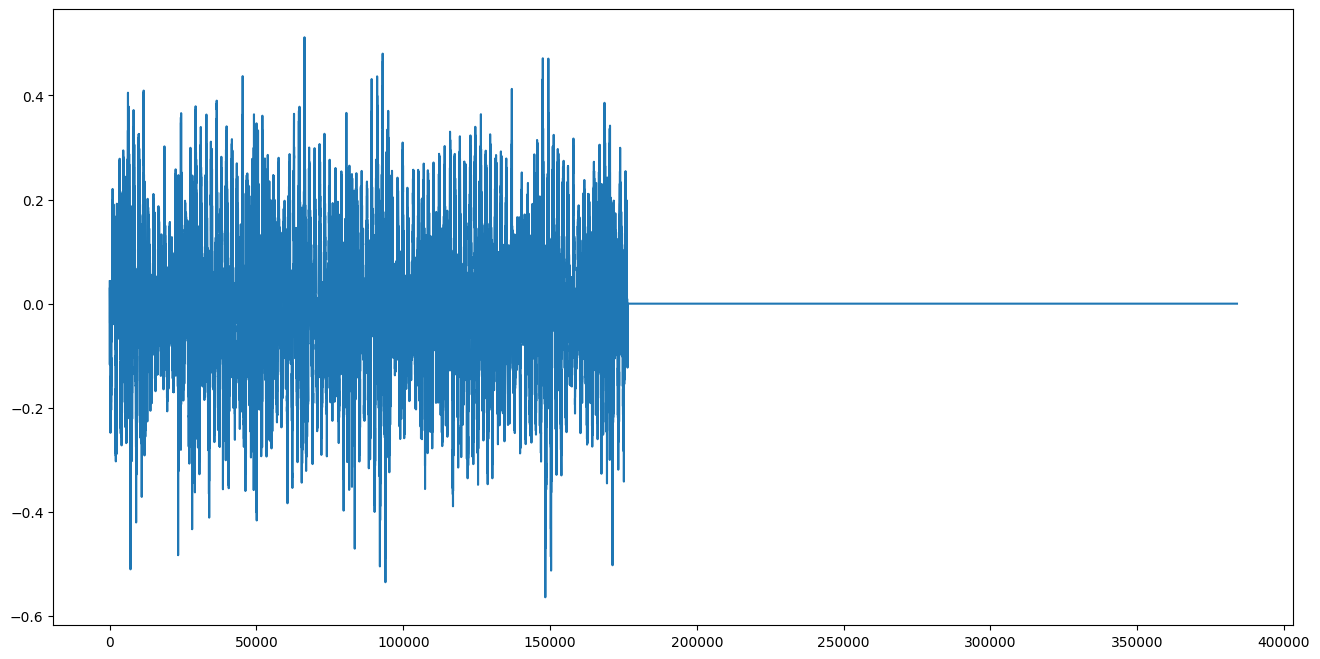

In [ ]:
# нарисуем и проиграем аудиозаписить
item = train_dataset.__getitem__(0)
plt.figure(figsize=(16, 8))
plt.plot(item["x"])

display.Audio(item["x"], rate=train_dataset.sr)

In [ ]:
# создадим даталоадеры
train_dataloader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, pin_memory=True, drop_last=True
)
val_dataloader = DataLoader(val_dataset, batch_size=32, pin_memory=True)

## Задание 2. Рекуррентная сеть для классификации аудиозаписей по сырому сигналу (2 балла)

По своей сути аудиозапись является ни чем иным, как временным рядом - замеры микрофона делаются через равные промежутки времени и хранятся в виде последовательности.

Как известно, рекуррентные сети отлично подходят для работы с различными последовательностями, в том числе и с временными рядами.

Обучим простую реккурентную сеть для классификации аудиозаписей.

1. Разбейте аудизаписить на окошки размером `1024` с шагом `256`. Для этих целей отлично подойдет метод `torch.Tensor.unfold`.
1. Применим к каждому получившемуся окну аудиосигнала полносвязную сеть с активациями `ReLU` и  внутренними размерностям `(1024 -> 256 -> 64 -> 16)`.
2. По получившимся последовательностям пройдемся двунаправленой (`bidirectional=True`) LSTM с двумя слоями (`layers=2`).
3. Склеим c помощью `torch.cat` последние `hidden_state` для каждого слоя и применим к ним полносвязную сеть `(2 * hidden_size * num_layers -> 256 -> 10)` с активацией `ReLU`.

<center>
<img src="https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2020-2023/2022/hw/hw2/imgs/rnn_raw.png" height="500">
</center>

*Совет*: для убыстрения обучения имеет смысл в полносвязные сети добавить `BatchNorm`.

In [ ]:
class RecurrentRawAudioClassifier(nn.Module):
    def __init__(
        self,
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2,
    ) -> None:
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length


        self.first_mlp = nn.Sequential(
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU()
            )

        self.rnn = nn.LSTM(
            input_size=16,
            hidden_size=hidden,
            num_layers=2,
            bidirectional=True
            )

        self.final_mlp = nn.Sequential(
            nn.Linear(2 * hidden * num_layers, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(hidden, 10),
            nn.BatchNorm1d(10),
            nn.ReLU()
            )


    def forward(self, x, lens) -> torch.Tensor:
        # разбейте сигнал на окна
        # batch_windows.shape == (B, NUM WINDOWS, 1024)
        batch_windows = x.unfold(1, 1024, 256)

        # примените к каждому окну полносвязную сеть
        # batch_windows_feautures.shape == (B, NUM WINDOWS, 16)
        batch_windows_feautures = torch.stack(list(map(self.first_mlp, batch_windows))).permute(1, 0, 2)

        # примените к получившемся последовательностям LSTM и возьмите hidden state
        res_rnn, (hidden_state, res_state) = self.rnn(batch_windows_feautures)

        # склейте hidden_state по слоям
        # hidden_flattened.shape = (B, 2 * hidden_size * num_layers)
        hidden_flattened = torch.stack(list(map(torch.flatten, hidden_state.permute(1, 0, 2))))

        # примените полносвязную сеть и получим логиты классов
        return self.final_mlp(hidden_flattened)

Обучим получившуюся модель.

In [ ]:
def train_audio_clfr(
    model,
    optimizer,
    train_dataloader,
    sr,
    criterion=torch.nn.CrossEntropyLoss(),
    data_transform=None,
    augmentation=None,
    num_epochs=10,
    device="cuda:0",
    verbose_num_iters=10,
):
    model.train()
    iter_i = 0

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        for batch in train_dataloader:
            x = batch["x"].to(device)
            y = batch["y"].to(device)
            lens = batch["len"].to(device)

            # применяем преобразование входных данных
            if data_transform:
                x, lens = data_transform(x, lens, device=device, sr=sr)

            # примеменяем к логмелспектрограмме аугментацию
            if augmentation:
                x, lens = augmentation(x, lens)

            probs = model(x, lens)
            optimizer.zero_grad()
            loss = criterion(probs, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            # считаем точность предсказания
            pred_cls = probs.argmax(dim=-1)
            train_accuracies.append((pred_cls == y).float().mean().item())

            iter_i += 1

            # раз в verbose_num_iters визуализируем наши лоссы и семплы
            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)

                print(f"Epoch {epoch}")

                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.xlabel("Iteration")
                plt.ylabel("Train loss")
                plt.plot(np.arange(iter_i), train_losses)

                plt.subplot(1, 2, 2)
                plt.xlabel("Iteration")
                plt.ylabel("Train acc")
                plt.plot(np.arange(iter_i), train_accuracies)

                plt.show()

    model.eval()

In [ ]:
# создадим объекты модели и оптимизатор
rnn_raw = RecurrentRawAudioClassifier()
rnn_raw.to(device)
optim = torch.optim.Adam(rnn_raw.parameters(), lr=3e-4)

Epoch 9


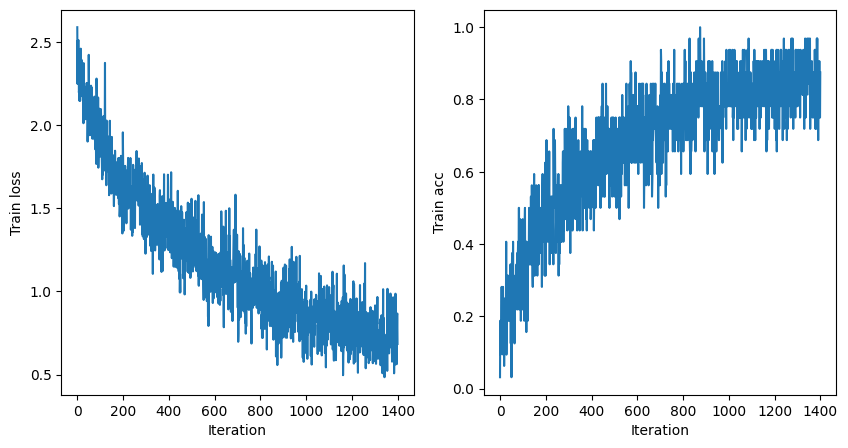

In [ ]:
# обучим модель
train_audio_clfr(rnn_raw, optim, train_dataloader, train_dataset.sr)

Посчитаем метрики на валидационном датасете.

In [ ]:
def plot_confusion_matrix(model, val_dataloader, sr, device, data_transform=None):
    pred_true_pairs = []
    for batch in val_dataloader:
        x = batch["x"].to(device)
        y = batch["y"].to(device)
        lens = batch["len"].to(device)

        with torch.no_grad():
            if data_transform:
                x, lens = data_transform(x, lens, sr=sr, device=device)

            probs = model(x, lens)

            pred_cls = probs.argmax(dim=-1)

        for pred, true in zip(pred_cls.cpu().detach().numpy(), y.cpu().numpy()):
            pred_true_pairs.append((pred, true))

    print(f"Val accuracy: {np.mean([p[0] == p[1] for p in pred_true_pairs])}")

    cm_df = pd.DataFrame(
        confusion_matrix(
            [p[1] for p in pred_true_pairs],
            [p[0] for p in pred_true_pairs],
            normalize="true",
        ),
        columns=classes,
        index=classes,
    )
    sn.heatmap(cm_df, annot=True)

Val accuracy: 0.14331550802139037


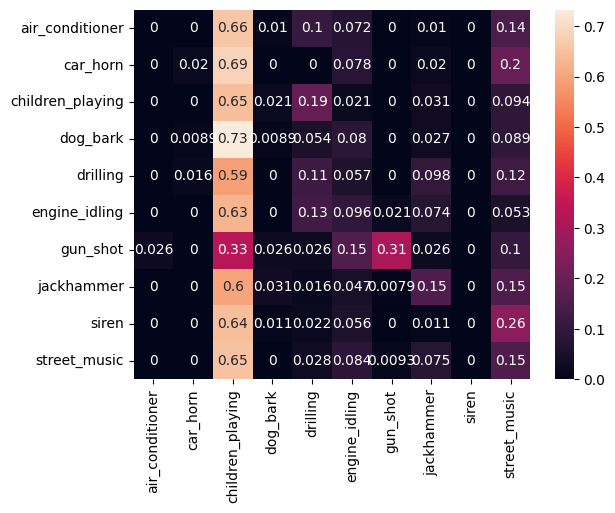

In [ ]:
plot_confusion_matrix(rnn_raw, val_dataloader, train_dataset.sr, device)

*Вопрос* : Сильно ли отличается качество модели на тренировочной и валидационной выборке? Если да, то как думаете, в чем причина?

-----
-----

Качество значительно различается: если на тренировочной выборке показатель accuracy, судя по графику, достигал значения 0.9, то на валидационной выборке показатель составил всего 0.143.

Низкое качество модели на валидационной выборке иллюстрирует матрица accuracy. В идеальном варианте это должна быть единичная матрица: по главной диагонали должны стоять значения 1.0, а в остальных ячейках должны стоять значения 0.0. Однако в получившейся матрице большие значения стоят преимущественно в одном столбике (children_playing или другой в зависимости от хода обучения), следовательно, модель стала определять для объектов преимущественно один класс и, таким образом, переобучилась. Возможно, это связано с тем, что модель принимала на вход необработанные (raw) аудиозаписи: для одной категории модель научилась распознавать, например, определенный шум на заднем плане, который может встречаться и в аудиозаписях других категорий.

-----
-----

## Задание 3. Построение Мел-cпектрограмм. (2 балла)

Сырой сигнал очень чувствителен ко многим факторам - увеличение/уменьшение громкости, внешние шумы, сменение тембра говорящего очень резко меняют сырой сигнал. Это влияет и на качество глубоких сетей, обученных на сыром аудиосигнале.

Для построения надежных и устойчивых к переобучению моделей используют другое представление аудиоданных - спектрограммы, в том числе Мел-спектрограмму.

Идея её построения заключается в следующем:
1. Сигнал разбивается на временные интервалы (с пересечениями)
2. К каждому временному интервалу применяется фильтр (как правило косинусоидальный)
3. К профильтрованному сигналу применяется дискретное преобразование Фурье и вычисляются спектральные признаки сигнала.
4. Спектральные признаки с помощью логарифмического преобразования приводятся в Мел-шкалу.

<center>
<img src="https://antkillerfarm.github.io/images/img2/Spectrogram_5.png" height="550">
</center>

В этом задании мы сами шаг за шагом напишем алгоритм построения мелспектрограммы и сравнимся с референсной функцией из `torchaudio`.

In [ ]:
from torchaudio.transforms import MelSpectrogram


# референсная функця
def compute_log_melspectrogram_reference(wav_batch, lens, sr, device="cpu"):
    featurizer = MelSpectrogram(
        sample_rate=sr,
        n_fft=1024,
        win_length=1024,
        hop_length=256,
        n_mels=64,
        center=False,
    ).to(device)

    return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256

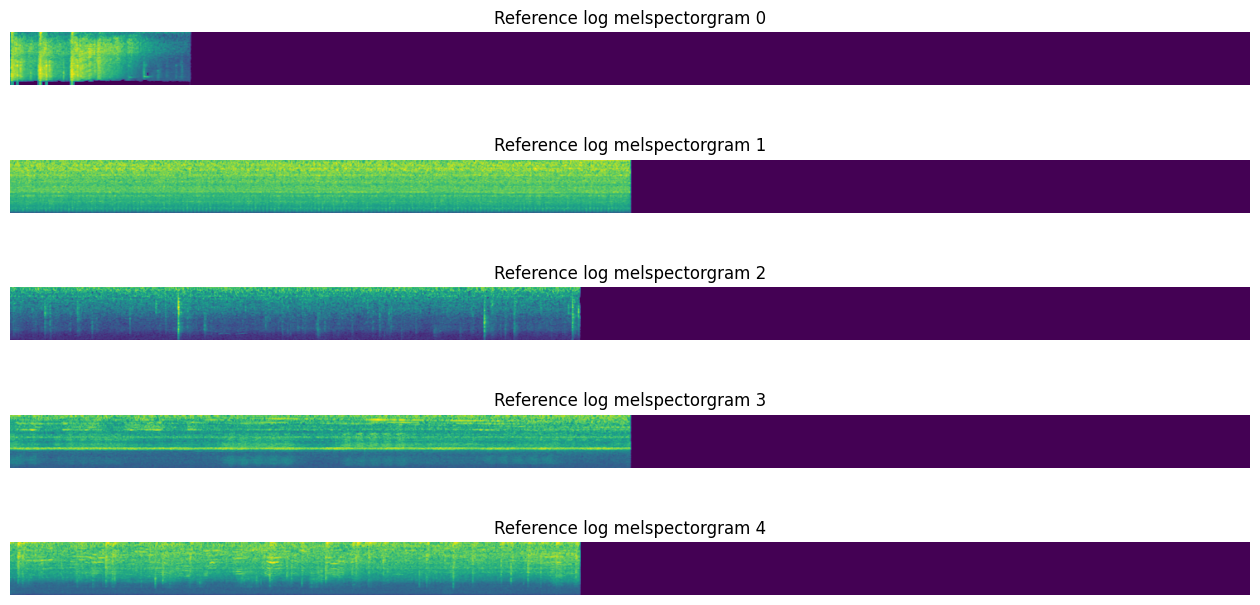

In [ ]:
# возьмем случайный батч
for batch in train_dataloader:
    break

wav_batch = batch["x"]
lens = batch["len"]

# посчитаем лог мелспектрограммы
log_melspect, lens = compute_log_melspectrogram_reference(
    wav_batch, lens, train_dataset.sr
)

# нарисуем получившиеся референсные значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Reference log melspectorgram {i}")
    axes[i].imshow(log_melspect[i].numpy())

Теперь сделаем то же самое сами.

In [ ]:
sr = train_dataset.sr
n_fft = 1024
win_length = 1024
hop_length = 256
n_mels = 64


Для начала с помощью метода `unfold` разделим аудиосигнал на окна размера `win_lenght` через промежутки `hop_lenght`.

In [ ]:
windows = wav_batch.unfold(1, win_length, hop_length)
assert windows.shape == (32, 1497, 1024)

Нарисуем и проиграем сигнал из одного окна.

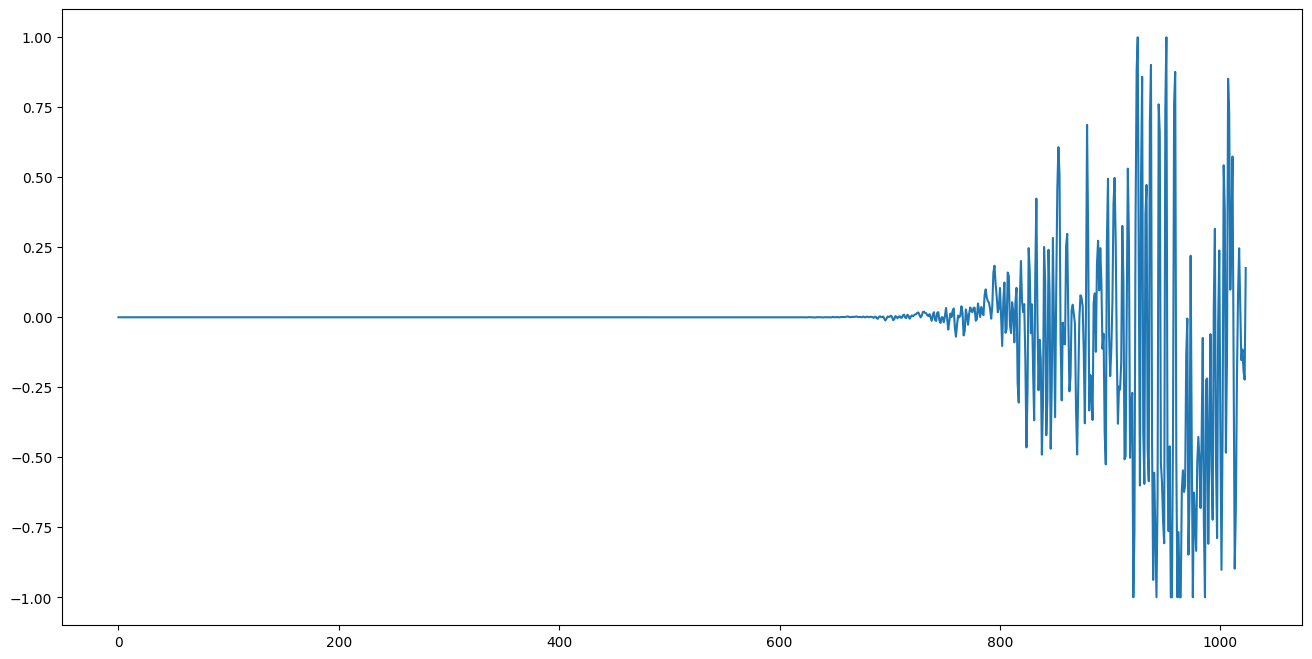

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(windows[0, 0])

display.Audio(windows[0, 0], rate=train_dataset.sr)

Теперь нам надо применить косинуисальный фильтр к сигналу из окна. Для этого с помощью `torch.hann_window` создадим косинусоидальный фильтр и умножим его поэлементно на все окна.

In [ ]:
filter = torch.hann_window(win_length)
windows_with_applied_filter = windows * filter[None, None, :]

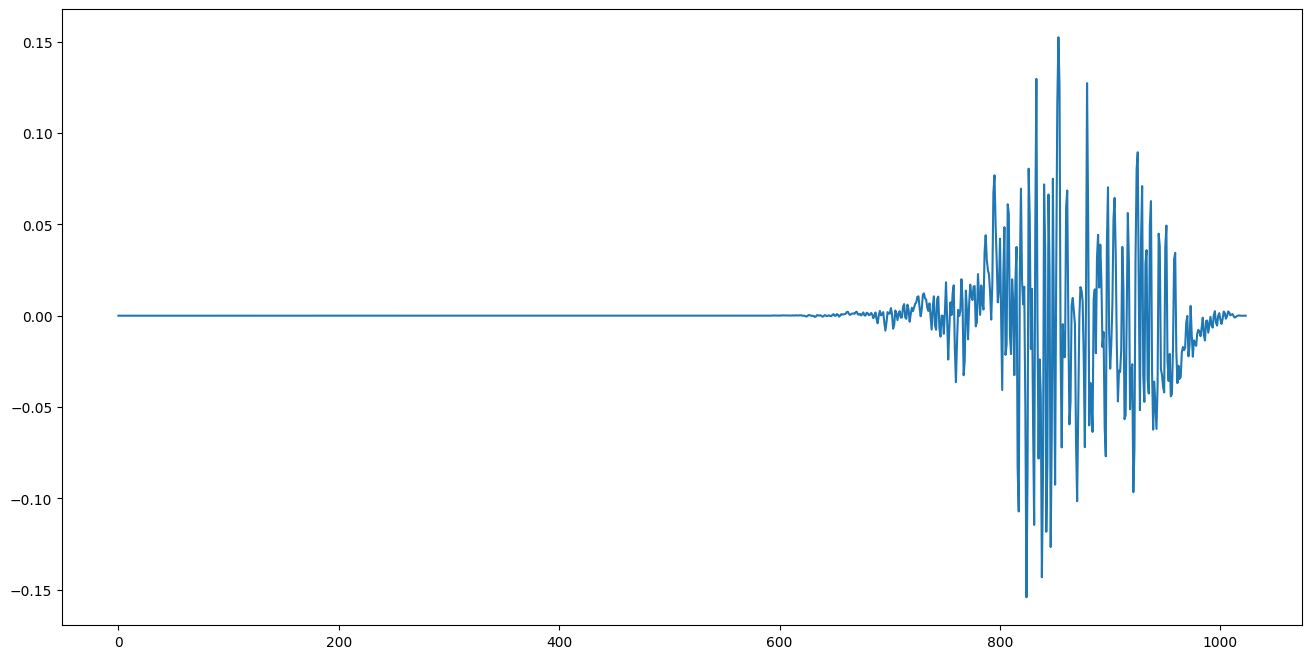

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(windows_with_applied_filter[0, 0])

display.Audio(windows_with_applied_filter[0, 0], rate=train_dataset.sr)

С помощью `torch.fft.fft` примените дискретное преобразование фурье к каждому окну и возьмите первые `n_fft // 2 + 1` компоненты.

Дальше с помощью возведения элементов тензора в квадрат и `torch.abs()` получите магнитуды.

In [ ]:
fft_features = torch.fft.fft(windows_with_applied_filter)[:, :, :n_fft // 2 + 1]
fft_magnitudes = torch.abs(fft_features**2)
assert fft_magnitudes.shape == (32, 1497, 513)

Через `torchaudio.transforms.MelScale` создайте класс для перевода магнитуд в Мел-шкалу.

In [ ]:
melscale = torchaudio.transforms.MelScale(
    n_mels=n_mels,
    sample_rate=sr,
    n_stft=n_fft // 2 + 1
)

Нелинейное преобразование для перевода в Мел-шкалу выглядит следующим образом.

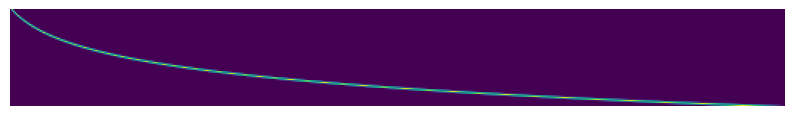

In [ ]:
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.imshow(melscale.fb.numpy().transpose())

Примените Мел-шкалу к магнитудам.

In [ ]:
mel_values = []
for i in range(fft_magnitudes.shape[0]):
    mel_values.append(melscale(fft_magnitudes[i].T))

mel_spectrogram = torch.stack(mel_values)

assert mel_spectrogram.shape == (32, 64, 1497)

Сделайте обрезку значений по `1e-5` и примените `torch.log` для получения логарифмированной Мел-спектрограммы.

In [ ]:
logmel_spectrogram = torch.log(mel_spectrogram.clamp(1e-5))
assert logmel_spectrogram.shape == (32, 64, 1497)

Полученные логарифмированные Мел-Спектрограммы должны совпадать с референсными.

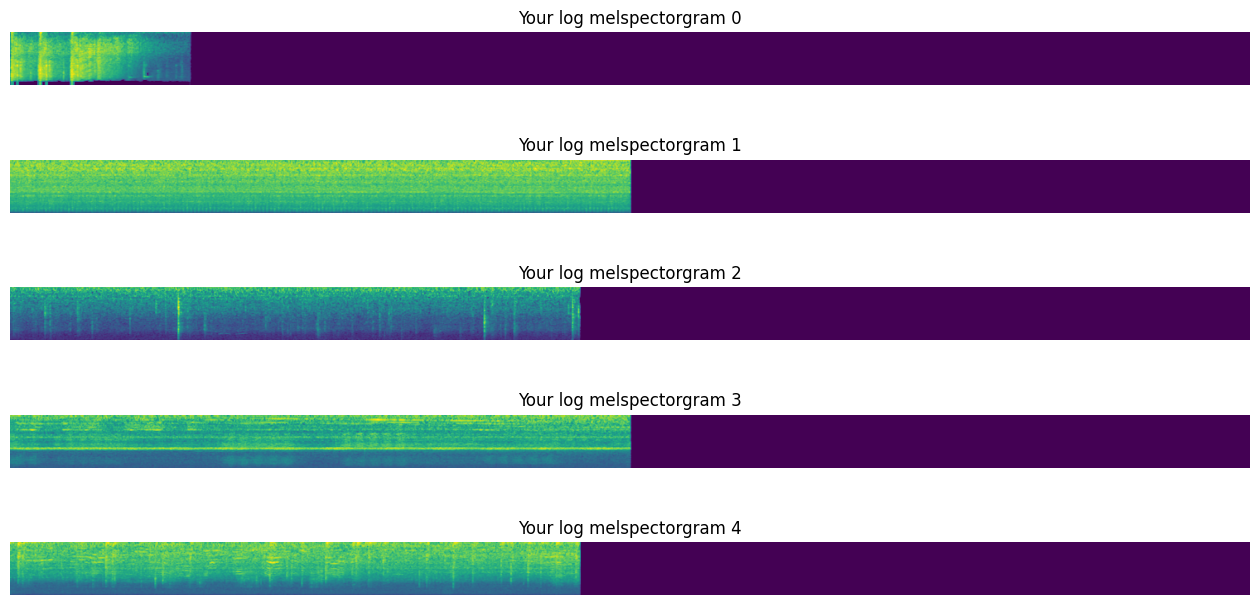

In [ ]:
# нарисуем получившиеся значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Your log melspectorgram {i}")
    axes[i].imshow(logmel_spectrogram[i].numpy())

Теперь оформим эту логику в функцию.

In [ ]:
# ваша реализация
def compute_log_melspectrogram(wav_batch, lens, sr, device="cpu"):
    windows = wav_batch.unfold(1, win_length, hop_length).to(device)

    filter = torch.hann_window(win_length, device=device)
    windows_with_applied_filter = windows * filter[None, None, :].to(device)

    fft_features = torch.fft.fft(windows_with_applied_filter, n=n_fft)[:, :, :n_fft // 2 + 1].to(device)
    fft_magnitudes = torch.abs(fft_features**2).to(device)

    melscale = torchaudio.transforms.MelScale(
    n_mels=n_mels,
    sample_rate=sr,
    n_stft=n_fft // 2 + 1
    ).to(device)

    mel_values = []
    for i in range(fft_magnitudes.shape[0]):
      mel_values.append(melscale(fft_magnitudes[i].T).to(device))

      mel_spectrogram = torch.stack(mel_values).to(device)
      logmel_spectrogram = torch.log(mel_spectrogram.clamp(1e-5)).to(device)

    return logmel_spectrogram, lens // 256

Финальная проверка.

In [ ]:
assert torch.allclose(
    compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)[0],
    compute_log_melspectrogram(wav_batch, lens, train_dataset.sr)[0],
    atol=1e-5,
)

## Задание 4. Рекуррентная сеть для классификации аудиозаписей по логарифмированным Мел-спектрограммам (1 балл)

Измените реализацию рекуррентной сети из задания 2, таким образом, чтобы она вместо сырого сигнала смогла принимать логарифмированные Мел-спетрограммы:
1. Уберите шаги 1-2
2. Сделайте вход LSTM равным 64

<center>
<img src="https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2020-2023/2022/hw/hw2/imgs/rnn_mel.png" height="500">
</center>

**За реализацию архитектуры дается 0.5 балла.**

In [ ]:
class RecurrentMelSpectClassifier(nn.Module):
    def __init__(
        self,
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2,
    ) -> None:
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length


        self.rnn = nn.LSTM(
            input_size=64,
            hidden_size=hidden,
            num_layers=2,
            bidirectional=True
            )

        self.final_mlp = nn.Sequential(
            nn.Linear(2 * hidden * num_layers, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(hidden, 10),
            nn.BatchNorm1d(10),
            nn.ReLU()
            )


    def forward(self, x, lens):
        # примените к получившемся последовательностям LSTM и возьмите hidden state
        res_rnn, (hidden_state, res_state) = self.rnn(x.permute(2, 0, 1))

        # склейте hidden_state по слоям
        # hidden_flattened.shape = (B, 2 * hidden_size * num_layers)
        hidden_flattened = torch.stack(list(map(torch.flatten, hidden_state.permute(1, 0, 2))))

        # примените полносвязную сеть и получим логиты классов
        return self.final_mlp(hidden_flattened)

In [ ]:
rnn_mel = RecurrentMelSpectClassifier()
rnn_mel.to(device)

optim = torch.optim.Adam(rnn_mel.parameters(), lr=3e-4)

Epoch 9


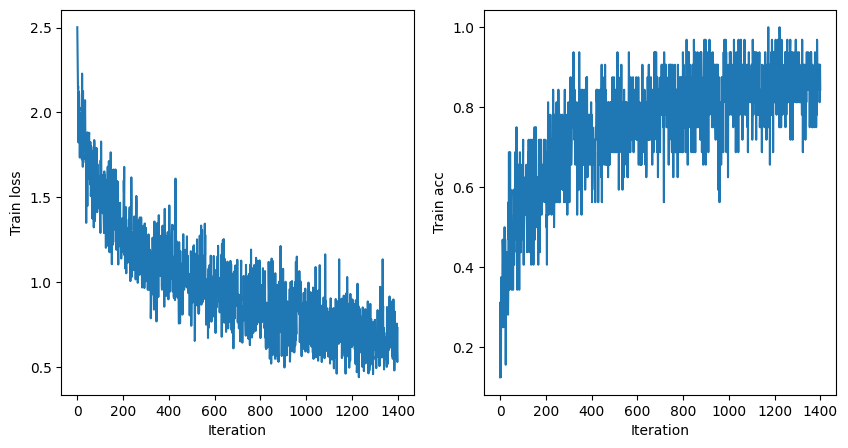

In [ ]:
train_audio_clfr(
    rnn_mel,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
)

Посчитаем метрики на валидационном датасете.

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.8 на валидационном датасете.**

Val accuracy: 0.8213903743315508


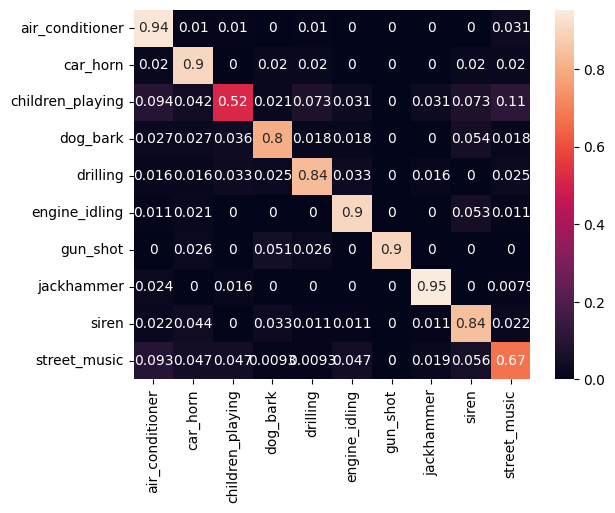

In [ ]:
plot_confusion_matrix(
    rnn_mel,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)

## Задание 5. Cверточная сеть для классификации аудиозаписей по мелспектрограммам. (2 балла)

Легко заметить, что мелспектрограммы имеют четко выраженные паттерны - если приноровиться, то даже человек, посмотрев на мелспектрограмму, сможет _визуально_ проклассифицировать объект.

Это позволяет свести задачу классификации аудиозаписей к задаче классификации картинок.

Реализуем такую сверточную сеть:

* 2x (Conv2d 3x3 @ 16, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 32, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 64, BatchNorm2d, ReLU)
* MaxPoll 2x2
* (Conv2d 3x3 @ 128, BatchNorm2d, ReLU)
* (Conv2d 2x2 @ 128, BatchNorm2d, ReLU)
* Global MaxPoll
* Fully Connected 128, ReLU
* Fully Connected 10

Совет: подобная архитектура была реализована в [**PANNs: Large-Scale Pretrained Audio Neural Networks for Audio Pattern Recognition**](https://arxiv.org/pdf/1912.10211.pdf), можете использовать эту статью как референс.


**За реализацию архитектуры дается 1.5 балла.**

-----
-----

Использовалась статья из задания ([PANNs: Large-Scale Pretrained Audio Neural Networks for Audio Pattern Recognition](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Farxiv.org%2Fpdf%2F1912.10211.pdf)), а также ресурс, в котором указан способ реализации слоя Global Max Pooling ([ссылка на ресурс](https://www.codetd.com/en/article/15137306)).

-----
-----

In [ ]:
class CNN10(nn.Module):
    def __init__(self, num_classes=10, hidden=16):
        super().__init__()


        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.AdaptiveMaxPool2d(128)
            )

        self.final_mlp = nn.Sequential(
            nn.Linear(128, 128),
#            nn.BatchNorm1d(128), отсутствует в условии задачи
            nn.ReLU(),
            nn.Linear(128, 10),
#            nn.BatchNorm1d(10), отсутствует в условии задачи
#            nn.ReLU() отсутствует в условии задачи
            )


    def forward(self, x, lens):
        z = self.cnn_backbone(x[:, None, :, :])
        z = torch.nn.functional.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]
        return self.final_mlp(z)

In [ ]:
cnn = CNN10()
cnn.to(device)

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 19


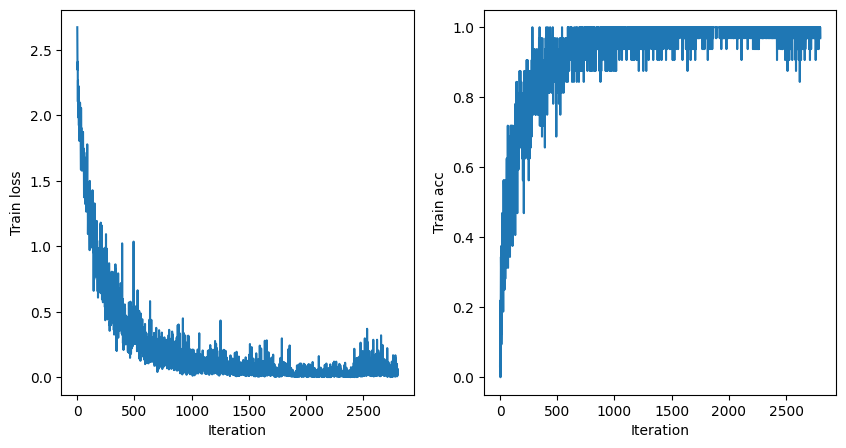

In [ ]:
train_audio_clfr(
    cnn,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
    num_epochs=20,
)

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.85 на валидационном датасете.**

Val accuracy: 0.9133689839572192


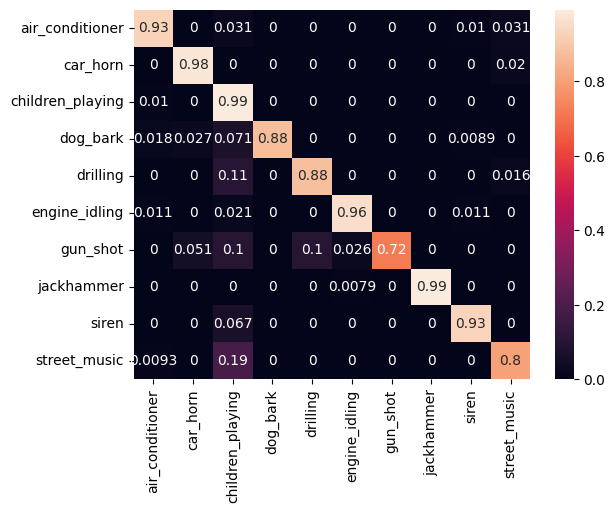

In [ ]:
plot_confusion_matrix(
    cnn,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)

## Задание 6. Аугментация SpecAugment (2 балла)

Обычно датасеты с аудиозаписями довольно малы. Наш датасет тому пример - всего 4500 объектов в обучающей выборке. Обучение глубокий сетей с большим кол-вом параметров на таких датасетах часто ведет к переобучению и проседанию метрик на валидационном и тестовом датасетах.

Для борьбы с переобучением имеет смысл использовать аугментацию данных. Для мелспектрограмм была придумана аугментация под названием SpecAugment.

Смысл её очень прост - зануление спектрограммы по временным промежуткам и по мел-частотам:
1. Выбираются несколько временных промежутков ${[t^1_i, t^2_i]}$ и заполняют спектрограмму $s[t^1_i : t^2_i, :]$ значением $v$.

2. Выбираются несколько промежутков мелчастот ${[m^1_i, m^2_i]}$ и заполняют спектрограмму $s[:, m^1_i : m^2_i]$ значением $v$.

В качестве значения $v$ выбирают:
1. `'mean'`: среднее по спектрограмме
2. `'min'`: минимум по спектрограмме
3. `'max'`: максимум по спектрограмме
5. `v`: некоторая константа

Совет: описание аугментации можно найти здесь: [link](https://neurohive.io/ru/novosti/specaugment-novyj-metod-augmentacii-audiodannyh-ot-google-ai/), можете использовать эту ссылку как референс.

![specaugment](https://neurohive.io/wp-content/uploads/2019/04/image6.png)

В этом задании Вам предлагается реализовать аугментацию SpecAugment.

**За реализацию аугментации дается 1.5 балла.**


-----
-----

Разобраться в принципе работы SpecAugment помогла [ссылка](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fneurohive.io%2Fru%2Fnovosti%2Fspecaugment-novyj-metod-augmentacii-audiodannyh-ot-google-ai%2F) из задания и еще две, связанные с ней: [первая](https://pytorch.org/audio/stable/tutorials/audio_feature_augmentation_tutorial.html) и [вторая](https://github.com/DemisEom/SpecAugment).

-----
-----

In [ ]:
import random


class SpectAugment:
    def __init__(
        self,
        filling_value="mean",
        n_freq_masks=2,
        n_time_masks=2,
        max_freq=10,
        max_time=50,
    ):

        self.filling_value = filling_value
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks
        self.max_freq = max_freq
        self.max_time = max_time

    def __call__(self, spect, lens):
        if self.filling_value == 'mean':
          actual_fv = torch.mean(spect)

        elif self.filling_value == 'min':
          actual_fv = torch.min(spect)

        elif self.filling_value == 'max':
          actual_fv = torch.max(spect)

        else:
          actual_fv = self.filling_value.to(torch.float32)

        for i in range(self.n_freq_masks):
            h_line_width = int(random.uniform(0.0, self.max_freq))
            h_line_start = int(random.uniform(0.0, spect.shape[1] - h_line_width))
            spect[:, h_line_start : h_line_start + h_line_width, :] = actual_fv

        for i in range(self.n_time_masks):
            v_line_width = int(random.uniform(0.0, self.max_time))
            v_line_start = int(random.uniform(0.0, spect.shape[2] - v_line_width))
            spect[:, :, v_line_start : v_line_start + v_line_width] = actual_fv

        return spect, lens//256

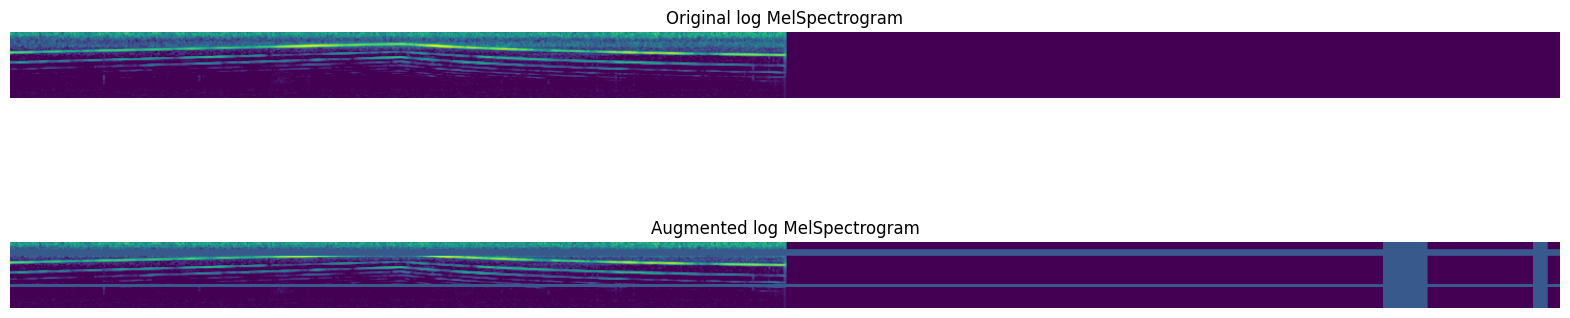

In [ ]:
# применим аугментацию к данным
for batch in train_dataloader:
    break

x = batch["x"].to(device)
lens = batch["len"].to(device)
x_logmel, lens = compute_log_melspectrogram_reference(
    x, lens, sr=train_dataset.sr, device=device
)
x_logmel2, lens = compute_log_melspectrogram_reference(
    x, lens, sr=train_dataset.sr, device=device
)
x_logmel_augmented, lens = SpectAugment()(x_logmel2, lens)

# нарисуем спектрограмму до и после аугментации
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.title("Original log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel[0].cpu().numpy())

plt.subplot(2, 1, 2)
plt.title("Augmented log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel_augmented[0].cpu().numpy())

plt.show()

In [ ]:
cnn = CNN10()
cnn.to(device)

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 29


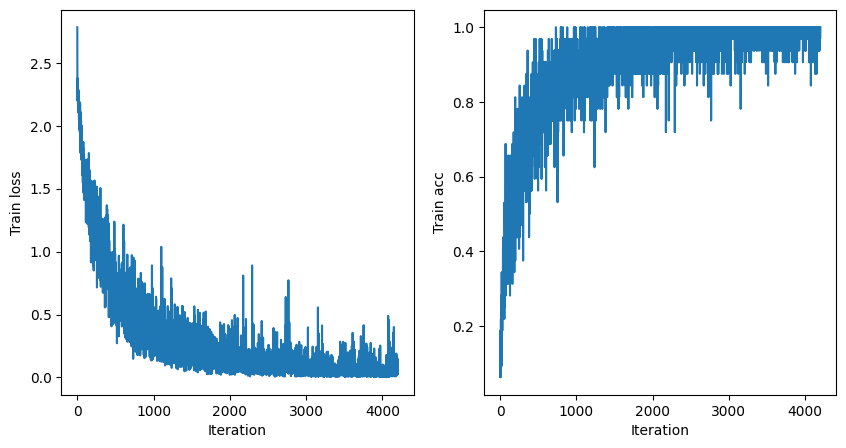

In [ ]:
# обучим модель на данных с аугментациями
train_audio_clfr(
    cnn,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
    augmentation=SpectAugment(
        filling_value="mean",
        n_freq_masks=2,
        n_time_masks=2,
        max_freq=5,
        max_time=50),
    num_epochs=30,
)

**Задание: для получения 0.5 балла сделайте подбор параметров аугментации и добейтесь accuracy модели выше 0.9 на валидационном датасете.**

Val accuracy: 0.9283422459893048


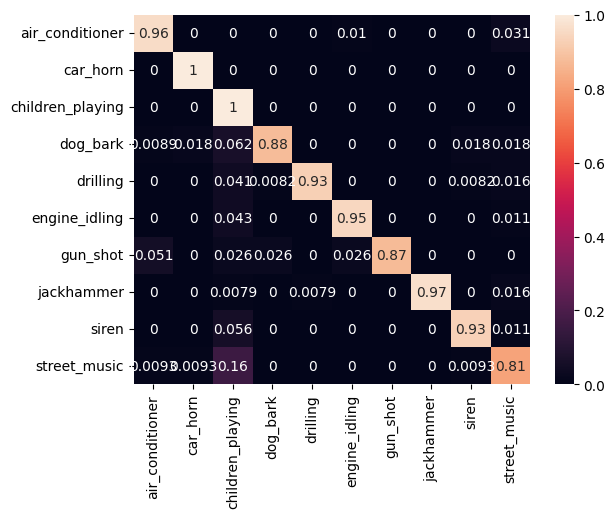

In [ ]:
plot_confusion_matrix(
    cnn,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)